## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import missingno as msno

from utils import *

import xgboost as xgb
from xgboost import XGBClassifier

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, roc_auc_score, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier

# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# magic word for producing visualizations in notebook
%matplotlib inline

# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [11, 7]

Using TensorFlow backend.


## Load Dataset

In [2]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?'], engine='python')

In [3]:
census_columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veteran\'s admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'income class'
]
census.columns = census_columns
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

 ## Clean Dataset

In [5]:
census = clean_dataset(census)
census.head()

Memory usage of dataframe:  50.234031677246094  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 34.440794944763184 MB
This is 68.56% of the initial size


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,major industry code,major occupation code,race,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,year,income class
0,73,NaN,0,0,High school graduate,0,Widowed,NaN,NaN,White,...,0,United-States,United-States,United-States,Native- Born in the United States,0,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Divorced,Construction,Precision production craft & repair,White,...,1,United-States,United-States,United-States,Native- Born in the United States,0,2,52,94,0
2,18,NaN,0,0,10th grade,0,Never married,NaN,NaN,Asian or Pacific Islander,...,0,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,2,0,95,0
3,9,NaN,0,0,Children,0,Never married,NaN,NaN,White,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,0
4,10,NaN,0,0,Children,0,Never married,NaN,NaN,White,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,0


In [6]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 33 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  uint8 
 1   class of worker                          99278 non-null   object
 2   detailed industry recode                 199523 non-null  uint8 
 3   detailed occupation recode               199523 non-null  uint8 
 4   education                                199523 non-null  object
 5   wage per hour                            199523 non-null  uint16
 6   marital status                           199523 non-null  object
 7   major industry code                      98839 non-null   object
 8   major occupation code                    98839 non-null   object
 9   race                                     199523 non-null  object
 10  hispanic origin                          198

## Split train and validation sets

In [7]:
X = census.drop('income class', axis=1)
y = census['income class']

In [8]:
y.mean()

0.06205800834991455

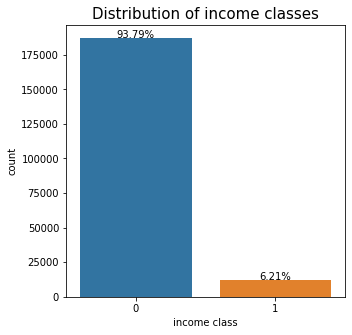

In [9]:
class_distribution(census[['income class']])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=666)

## Bayesian Hyperparameter Tuning with Hyperopt

### Simple Pipeline

In [35]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor)
])

In [37]:
X_tr = pipeline.fit_transform(X)

In [38]:
# Scoring and optimization functions
def objective_rus(params):
    print("Training with params: ")
    print(params)
    
    model = RUSBoostClassifier(n_estimators=int(params['n_estimators']), 
                               learning_rate=params['learning_rate'], 
                               random_state=666)
   
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    best_score = cross_val_score(model, X_tr, y, scoring='roc_auc', cv=2, n_jobs=5).mean()
    loss = 1 - best_score
    
    return {'loss': loss, 'status': STATUS_OK}

In [39]:
# Set up space dictionary with specified hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'learning_rate': hp.quniform('eta', 0.025, 1, 0.025),
}

# Run the algorithm
best = fmin(fn=objective_rus,space=space, max_evals=20, rstate=np.random.RandomState(666), algo=tpe.suggest)
best

Training with params:                                                                    
{'learning_rate': 0.7250000000000001, 'n_estimators': 577.0}                             
Training with params:                                                                    
{'learning_rate': 0.225, 'n_estimators': 614.0}                                          
Training with params:                                                                    
{'learning_rate': 0.15000000000000002, 'n_estimators': 886.0}                            
Training with params:                                                                    
{'learning_rate': 0.4, 'n_estimators': 80.0}                                             
Training with params:                                                                    
{'learning_rate': 0.05, 'n_estimators': 56.0}                                            
Training with params:                                                                    
{'learning

{'eta': 0.15000000000000002, 'n_estimators': 886.0}

In [41]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

model = Pipeline([
    ('pre', preprocessor),
    ('clf', RUSBoostClassifier(n_estimators=886, learning_rate=0.15, random_state=666))
])

In [42]:
model.fit(X_train, y_train);
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     56129
           1       0.29      0.89      0.44      3728

    accuracy                           0.86     59857
   macro avg       0.64      0.87      0.68     59857
weighted avg       0.95      0.86      0.89     59857

AUC: 0.8741214577975919


## Test

In [43]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census_test = pd.read_csv('data/census-income.test', header=None, sep=',\s', na_values=['?'], engine='python')

In [44]:
census_test.columns = census_columns
census_test.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


In [45]:
census_test = clean_dataset(census_test)
census_test.head()

Memory usage of dataframe:  25.117202758789062  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 17.220544815063477 MB
This is 68.56% of the initial size


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,major industry code,major occupation code,race,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,White,...,4,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,2,12,95,0
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Married-civilian spouse present,Business and repair services,Professional specialty,White,...,1,United-States,United-States,United-States,Native- Born in the United States,0,2,26,95,0
2,2,NaN,0,0,Children,0,Never married,NaN,NaN,White,...,0,United-States,United-States,United-States,Native- Born in the United States,0,0,0,95,0
3,35,Private,29,3,High school graduate,0,Divorced,Transportation,Executive admin and managerial,White,...,5,United-States,United-States,United-States,Native- Born in the United States,2,2,52,94,0
4,49,Private,4,34,High school graduate,0,Divorced,Construction,Precision production craft & repair,White,...,4,United-States,United-States,United-States,Native- Born in the United States,0,2,50,95,0


In [46]:
census_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   age                                      99762 non-null  uint8 
 1   class of worker                          49683 non-null  object
 2   detailed industry recode                 99762 non-null  uint8 
 3   detailed occupation recode               99762 non-null  uint8 
 4   education                                99762 non-null  object
 5   wage per hour                            99762 non-null  uint16
 6   marital status                           99762 non-null  object
 7   major industry code                      49479 non-null  object
 8   major occupation code                    49479 non-null  object
 9   race                                     99762 non-null  object
 10  hispanic origin                          99357 non-null  o

In [47]:
X_test = census_test.drop('income class', axis=1)
y_test = census_test['income class']

In [ ]:
#X_test_tr = pipeline.transform(X_test)

In [48]:
y_pred_test = model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     93576
           1       0.29      0.90      0.44      6186

    accuracy                           0.86     99762
   macro avg       0.64      0.88      0.68     99762
weighted avg       0.95      0.86      0.89     99762

AUC: 0.8783286739775186


## Prepare submission

In [50]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/submission.csv', index=False)